# TensorFlow2 DenseNet-BiLSTM-CRF

## 1.导入数据
使用BROOK数据集 Person1

In [53]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow import keras
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
import matplotlib.colors as colors
import tensorflow_addons as tfa
import os.path 
from tensorflow_addons.layers import CRF

In [54]:
txt_file = 'sc/train23.txt'
# txt_file = 'dataset/speedtxt/train.txt'
f = open(txt_file)
imgspaths = []
scs = []
for line in f.readlines():
    filename = line.split(',')[0]
    sc = line.split(',')[1]
    if sc[-1] == '\n':
        sc = sc[:-1]
        imgspaths.append(filename)
        scs.append(int(sc))
    
y_train = np.array(scs)



In [55]:
max_unit = np.max(scs)

In [56]:
txt_file = 'sc/test23.txt'
# txt_file = 'dataset/speedtxt/test.txt'
f = open(txt_file)
imgspath2 = []
scs = []
for line in f.readlines():
    filename = line.split(',')[0]
    sc = line.split(',')[1]
    if sc[-1] == '\n':
        sc = sc[:-1]
        imgspath2.append(filename)
        scs.append(int(sc))
y_test = np.array(scs)
        

In [57]:
# imgspaths = ['1565751556792.jpg','1565751556904.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg']
# imgspaths = ['1565751556792.jpg','1565751556904.jpg','1565751562024.jpg']
# y_train = [[53],[54],[55]]
x_train = []
for imgspath in imgspaths:
    path1 = 'dataset/train/'+imgspath
    path2 = 'dataset/test/'+imgspath
    path3 = 'dataset/val/'+imgspath
    path4 = '../Model-Training2/dataset/train/'+imgspath
    path5 = '../Model-Training2/dataset/test/'+imgspath
    path6 = '../Model-Training2/dataset/val/'+imgspath
    if os.path.exists(path1):
        img = np.array(Image.open(path1))
    elif os.path.exists(path2):
        img = np.array(Image.open(path2))
    elif os.path.exists(path3):
        img = np.array(Image.open(path3))
    elif os.path.exists(path4):
        img = np.array(Image.open(path4))
    elif os.path.exists(path5):
        img = np.array(Image.open(path5))
    else:
        img = np.array(Image.open(path6))
        
    img = colors.rgb_to_hsv(img)
    img = cv2.resize(img,(32,32))
    x_train.append(img)
x_train = np.array(x_train)

In [58]:
# imgspath2 = ['1565752827880.jpg']
# y_test = [[55]]
x_test = []
for imgspath in imgspath2:
    path1 = 'dataset/train/'+imgspath
    path2 = 'dataset/test/'+imgspath
    path3 = 'dataset/val/'+imgspath
    path4 = '../Model-Training2/dataset/train/'+imgspath
    path5 = '../Model-Training2/dataset/test/'+imgspath
    path6 = '../Model-Training2/dataset/val/'+imgspath
    if os.path.exists(path1):
        img = np.array(Image.open(path1))
    elif os.path.exists(path2):
        img = np.array(Image.open(path2))
    elif os.path.exists(path3):
        img = np.array(Image.open(path3))
    elif os.path.exists(path4):
        img = np.array(Image.open(path4))
    elif os.path.exists(path5):
        img = np.array(Image.open(path5))
    else:
        img = np.array(Image.open(path6))
        
    img = colors.rgb_to_hsv(img)
    img = cv2.resize(img,(32,32))
    x_test.append(img)
x_test = np.array(x_test)

In [59]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [60]:
validation_set = (x_test, y_test)

## CNN和LSTM结果合并

In [61]:
from tensorflow.keras import layers
model = keras.Sequential()

In [62]:
x_shape = x_train.shape
cnet2 = DenseNet201(
    input_shape=(x_shape[1], x_shape[2], x_shape[3]),
    weights='imagenet',
    include_top=False
)
cnet2.trainable = True
img_input = layers.Input(shape=(x_shape[1], x_shape[2], x_shape[3]))
base_model = cnet2(img_input)

# pool = layers.GlobalAveragePooling2D()(final_layer)
flat = layers.Flatten()(base_model)
dense1 = layers.Dense(64)(flat)

In [63]:
reshape = layers.Reshape(target_shape=(x_shape[1]*x_shape[2], x_shape[3]))(img_input)
lstm_layer = layers.Bidirectional(keras.layers.LSTM(50, return_sequences=True))(reshape)
decoded_sequence, potentials, sequence_length, chain_kernel = CRF(units=12)(lstm_layer)
dense2 = layers.Dense(64)(decoded_sequence)

In [64]:
merged_layer = layers.concatenate([dense1, dense2])
# merged_layer = dense1
outt = layers.Dense(max_unit + 1,activation='softmax')(merged_layer)
model = keras.Model(inputs=img_input, outputs=outt)
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 1024, 3)      0           input_8[0][0]                    
__________________________________________________________________________________________________
densenet201 (Functional)        (None, 1, 1, 1920)   18321984    input_8[0][0]                    
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 1024, 100)    21600       reshape_4[0][0]                  
______________________________________________________________________________________

In [65]:
%%time
history2 = model.fit(x_train, y_train, batch_size=64,epochs=200, validation_data = validation_set)

Epoch 1/200
240/240 [==============================] - 217s 902ms/step - loss: 4.1720 - accuracy: 0.2314 - val_loss: 26.0175 - val_accuracy: 0.0548
Epoch 2/200
240/240 [==============================] - 229s 956ms/step - loss: 2.1243 - accuracy: 0.4351 - val_loss: 4.8092 - val_accuracy: 0.1683
Epoch 3/200
240/240 [==============================] - 226s 941ms/step - loss: 1.7975 - accuracy: 0.5174 - val_loss: 7.7245 - val_accuracy: 0.1639
Epoch 4/200
240/240 [==============================] - 227s 947ms/step - loss: 1.4550 - accuracy: 0.5912 - val_loss: 2.3482 - val_accuracy: 0.4371
Epoch 5/200
240/240 [==============================] - 225s 938ms/step - loss: 1.2353 - accuracy: 0.6303 - val_loss: 3.2627 - val_accuracy: 0.3693
Epoch 6/200
240/240 [==============================] - 228s 949ms/step - loss: 1.0414 - accuracy: 0.6787 - val_loss: 3.7155 - val_accuracy: 0.2837
Epoch 7/200
240/240 [==============================] - 226s 941ms/step - loss: 0.9296 - accuracy: 0.7056 - val_loss: 

Epoch 42/200
240/240 [==============================] - 221s 922ms/step - loss: 0.2445 - accuracy: 0.9162 - val_loss: 1.8226 - val_accuracy: 0.6255
Epoch 43/200
240/240 [==============================] - 247s 1s/step - loss: 0.2613 - accuracy: 0.9124 - val_loss: 1.8904 - val_accuracy: 0.6240
Epoch 44/200
240/240 [==============================] - 238s 991ms/step - loss: 0.2148 - accuracy: 0.9266 - val_loss: 1.8672 - val_accuracy: 0.6268
Epoch 45/200
240/240 [==============================] - 224s 934ms/step - loss: 0.2242 - accuracy: 0.9241 - val_loss: 3.8177 - val_accuracy: 0.4601
Epoch 46/200
240/240 [==============================] - 222s 926ms/step - loss: 0.2504 - accuracy: 0.9207 - val_loss: 2.2010 - val_accuracy: 0.5381
Epoch 47/200
240/240 [==============================] - 227s 946ms/step - loss: 0.2325 - accuracy: 0.9241 - val_loss: 1.9276 - val_accuracy: 0.6026
Epoch 48/200
240/240 [==============================] - 229s 953ms/step - loss: 0.2138 - accuracy: 0.9291 - val_los

Epoch 98/200
240/240 [==============================] - 256s 1s/step - loss: 0.1626 - accuracy: 0.9560 - val_loss: 6.2111 - val_accuracy: 0.4147
Epoch 99/200
240/240 [==============================] - 475s 2s/step - loss: 0.1329 - accuracy: 0.9642 - val_loss: 2.4035 - val_accuracy: 0.6568
Epoch 100/200
240/240 [==============================] - 229s 956ms/step - loss: 0.1381 - accuracy: 0.9635 - val_loss: 2.1700 - val_accuracy: 0.6905
Epoch 101/200
240/240 [==============================] - 241s 1s/step - loss: 0.1196 - accuracy: 0.9650 - val_loss: 2.6412 - val_accuracy: 0.6720
Epoch 102/200
240/240 [==============================] - 244s 1s/step - loss: 0.0912 - accuracy: 0.9733 - val_loss: 2.9136 - val_accuracy: 0.6623
Epoch 103/200
240/240 [==============================] - 243s 1s/step - loss: 0.1506 - accuracy: 0.9598 - val_loss: 2.7028 - val_accuracy: 0.6503
Epoch 104/200
240/240 [==============================] - 255s 1s/step - loss: 0.1233 - accuracy: 0.9664 - val_loss: 1.4795 

240/240 [==============================] - 141s 587ms/step - loss: 0.0915 - accuracy: 0.9791 - val_loss: 4.0380 - val_accuracy: 0.6412
Epoch 154/200
240/240 [==============================] - 142s 590ms/step - loss: 0.0821 - accuracy: 0.9796 - val_loss: 5.4558 - val_accuracy: 0.5133
Epoch 155/200
240/240 [==============================] - 142s 590ms/step - loss: 0.1109 - accuracy: 0.9735 - val_loss: 1.5906 - val_accuracy: 0.7996
Epoch 156/200
240/240 [==============================] - 142s 592ms/step - loss: 0.1063 - accuracy: 0.9759 - val_loss: 2.7863 - val_accuracy: 0.7122
Epoch 157/200
240/240 [==============================] - 142s 591ms/step - loss: 0.0967 - accuracy: 0.9778 - val_loss: 8.1758 - val_accuracy: 0.4392
Epoch 158/200
240/240 [==============================] - 142s 591ms/step - loss: 0.1310 - accuracy: 0.9695 - val_loss: 3.6034 - val_accuracy: 0.6153
Epoch 159/200
240/240 [==============================] - 142s 591ms/step - loss: 0.1037 - accuracy: 0.9753 - val_loss: 2

In [66]:
model.evaluate(x=x_test, y=y_test,verbose=1)

120/120 [==============================] - 18s 150ms/step - loss: 2.0039 - accuracy: 0.8004


[2.003905773162842, 0.8003653287887573]

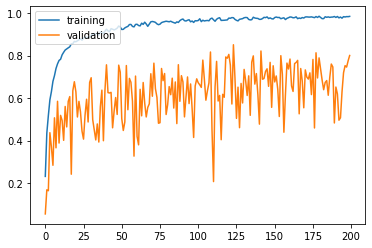

In [67]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='upper left')
plt.show()